# TME 4 : Premiers filtres

> Consignes: le fichier TME4_Sujet.ipynb est à déposer sur le site Moodle de l'UE https://moodle-sciences.upmc.fr/moodle-2019/course/view.php?id=4248. Si vous êtes en binôme, renommez-le en TME4_nom1_nom2.ipynb.

In [70]:
# Chargement des modules et des données utiles.

from PIL import Image
from pylab import *
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.signal

image_cameraman = np.array(Image.open("images/cameraman.png"))
image_cameraman_bruit_impuls = np.array(Image.open("images/cameraman_salt_peper_3pct.png")) # L'image du cameraman avec un bruit poivre et sel (3% des pixels) 
image_cameraman_bruit_gauss = np.array(Image.open("images/cameraman_gauss_noise.png")) # L'image du cameraman avec un bruit gaussien centré (Variance 0.01)
image_rectangle = np.array(Image.open("images/rectangle.png"))
image_bateau = np.array(Image.open("images/boat.png"))
image_bateau_bruit_impuls = np.array(Image.open("images/boat_salt_peper_5pct.png")) # L'image du bateau avec un bruit poivre et sel (5% des pixels) 
image_bateau_bruit_gauss = np.array(Image.open("images/boat_gauss_noise.png")) # L'image du bateau avec un bruit gaussien centré (Variance 0.03)

def affichage_comparaison(image_non_bruite, image_debruitee, image_bruitee):
    s1 = plt.subplot(131)
    s1.set_title("Non bruitée")
    s1.imshow(image_non_bruite, cmap="gray",interpolation='nearest', aspect='equal')
    s2 = plt.subplot(132)
    s2.set_title("Débruitée")
    s2.imshow(image_debruitee, cmap="gray",interpolation='nearest', aspect='equal')
    s3 = plt.subplot(133)
    s3.set_title("Bruitée")
    s3.imshow(image_bruitee, cmap="gray",interpolation='nearest', aspect='equal')

    agrandissement = 3
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement, plSize[1]*agrandissement) )
    plt.show()

## Partie 1 : Convolution d'une image par un filtre

Dans cette partie, on écrira une fonction pour réaliser la convolution linéaire d'une image en niveau de gris par un filtre. Cette fonction sera utile dans la partie 2 pour le filtre moyenneur et pour les séances de TME suivantes.

### Exercice 1.1 : Padding d'une image

Un padding de l'image est la première étape nécessaire pour réaliser une convolution linéaire. Elle consiste à ajouter N lignes et colonnes de pixels de valeur 0 autour de l'image pour un filtre de taille 2N+1.

**À faire**: Complétez la fonction ```padding_image(image, N)```.

Rappel: la taille d'une matrice ```M``` est donnée par ```M.shape```.

In [71]:
np.shape(image_cameraman)

(256, 256)

In [72]:
def padding_image(image, N):  
    """ Array*int -> Array 
    Réalise un zéro padding d'une image.
    """
     #valeurs
    (n, m)=np.shape(image)
     # nouvelle image est une numpyarray
    newImage=np.zeros(((n+2*N),(m+2*N)) )
    #newImage.astype(float32)
    #on copie l'image dans les bonnes coordonnées de newImage
    for i in range(N, N+n):
        for j in range(N, N+m):
            newImage[i][j]=image[i-N][j-N]
            
    return newImage   
   
    

In [73]:
padding_image(image_cameraman,1)

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0., 156., 159., ..., 152., 152.,   0.],
       [  0., 160., 154., ..., 155., 153.,   0.],
       ...,
       [  0., 121., 126., ..., 130., 113.,   0.],
       [  0., 121., 126., ..., 130., 113.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

Vous pouvez tester la fonction `padding_image()` avec la cellule suivante: vérifiez que la taille de l'image obtenue a les bonnes dimensions.

(266, 266)


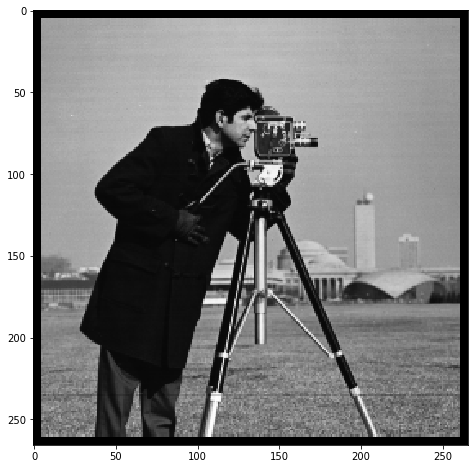

In [74]:
image_cameraman_pad = padding_image(image_cameraman,5)
print(image_cameraman_pad.shape)


plt.imshow(image_cameraman_pad, cmap="gray")
agrandissement = 2
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*agrandissement, plSize[1]*agrandissement) )
plt.show()

### Réponse:
dimensions de l'image trouvés: (266, 266), elles correspondent bien à ce qu'on veut car on ajoute 10 ligne/ colonnes de 0 de chaque coté

### Exercice 1.2 : Écriture de la fonction de convolution

Dans cette partie, on écrira une fonction ```convolution(image, filtre)``` qui calcule la convolution linéaire d'une image par un filtre. On utilisera la fonction ```padding_image()``` comme première étape.

On supposera que le filtre est un tableau de taille $(2N+1) \times (2N+1)$. 

PS: Il existe dans plusieurs modules Python des fonctions plus efficaces pour calculer un produit de convolution mais on s'interdira de les utiliser !

**À faire:** Complétez la fonction ```convolution(image, filtre)```.

In [75]:
# j' écris une fonction convolution appliquée à une seule case
"""
Entrées: 
image: image source dont on veut faire la convolution
newImage: image dans laquelle on stocke le résultat de la convolution
x, y: coordonnées d'une case dans l'image
filtre: filtre à appliquer avec la convolution
"""
def convol_case(image, x, y, filtre):
    #On sait que la taille de l'image est impair car sinon je risque de calculer la convolution avec les nouvelles 
    #valeurs après modification par la convolution
    (h,w)=filtre.shape
    d=(h-1)//2 
    value=0
    for i in range(x-d, x+d+1):
        for j in range(y-d, y+d+1):
            val=image[i][j]
            filtre_case=filtre[d+x-i][d+y-j]
            value+=val*filtre_case
    #application du filtre 
    return value

In [76]:
def convolution(image, filtre):
    """ Array*Array -> Array 
        retourne la convolution linéaire de image par filtre
    """
    #On récupère d'abord les dimension du filtre
    (l1,l2)=filtre.shape
    #on récupère la valeur N à donner en paramètres à padding
    N=(l1-1)//2
    print(N)
    
    #Appel de padding
    img=padding_image(image, N)
    #je crée une nouvelle image dans laquelle je stocke l'image résultat après convolution 
    (h,w)=image.shape
    newImage=np.zeros((h,w))
    #application du filtre de convolution sur chaque case de l'ancienne image dans la nouvelle image
    for i in range(0, h):
        for j in range(0, w):
            newImage[i][j]=convol_case(img, i+N, j+N, filtre)
    return newImage

Vous pouvez contrôler le bon fonctionnement de votre fonction en vérifiant qu'elle donne le même résultat que la fonction ```signal.convolve2d()``` du module ```scipy```. La norme de la différence doit être proche de 0.

In [77]:
from scipy.signal import convolve2d

filtre_test = np.array([[1,2,3],[4,5,6],[7,8,9]])
print("Norme de la différence: " + str(np.linalg.norm(convolution(image_cameraman, filtre_test) - convolve2d(image_cameraman, filtre_test, mode = 'same'))))


1
Norme de la différence: 0.0


### Réponse
Résultat du test:
Norme de la différence: 0.0
la fonction est réussie

## Exercice 1.3: Temps de calcul
À l'aide des fonctions ``tic()``et ``tac()`` du TME2, calculer les temps d'exécution des deux fonctions et commentez les résultats (utiliser une image de grande taille).

In [78]:
from time import process_time
mytime = 0
def tic():
    global mytime
    mytime = process_time()
def tac():
    global mytime
    print (process_time()-mytime)
    mytime = process_time()


####

## Partie 2 : Réduction de bruit par filtrage linéaire: le filtre moyenneur

Dans cette partie, on réalisera le filtrage d'une image par des filtres moyenneurs de plusieurs tailles.

### Exercice 2.1 : Écriture de la fonction qui réalise le filtre moyenneur

**À faire:** Complétez la fonction ```filtre_moyenneur(image, N)``` où $N$ correspond à un filtre moyenneurde taille $N\times N$. Vous utiliserez la fonction ```convolution()``` écrite à l'exercice précédent.

In [79]:
#entrée: taille N du filtre
def filtre_moyenneur(image, N):
    """ Array*int -> Array
        retourne l'image filtré par le filtre moyenneur de taille NxN
    """
    filtre_moyenneur=(1/N*N)*np.ones((N,N))
    image_filtree=convolve2d(image, filtre_moyenneur,mode = 'same')
    return image_filtree
    

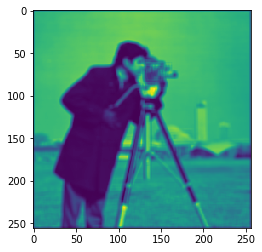

In [80]:
#Test
imshow(filtre_moyenneur(image_cameraman,5))


### Exercice 2.2 : Étude du filtre moyenneur sur une image de synthèse

On appliquera ici des filtres moyenneurs de différentes tailles de fenêtre sur l'image image_rectangle.

On affichera les images avant et après filtrage. On tracera également la ligne du milieu de l'image.

**À faire**: Afficher les images et les lignes millieu avant et après filtrage pour des filtres de taille $3\times3$, $9\times9$ et $21\times21$

Que conclure sur l'effet du filtre sur les contours ?

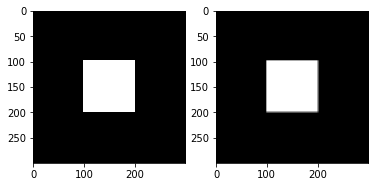

In [81]:
plt.subplot(1,2,1)
imshow(image_rectangle, cmap='gray')
plt.subplot(1,2,2)
imshow(filtre_moyenneur(image_rectangle,3), cmap='gray')

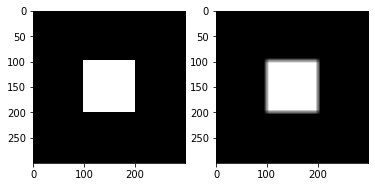

In [82]:
plt.subplot(1,2,1)
imshow(image_rectangle, cmap='gray')
plt.subplot(1,2,2)
imshow(filtre_moyenneur(image_rectangle,9), cmap='gray')

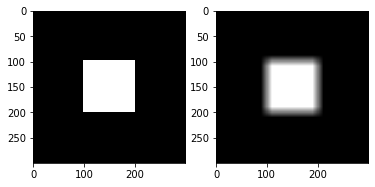

In [83]:
plt.subplot(1,2,1)
imshow(image_rectangle, cmap='gray')
plt.subplot(1,2,2)
imshow(filtre_moyenneur(image_rectangle,21), cmap='gray')

### Conclusion:
plus la taille du filtre moyenneur est grande, plus l'image est floutée et les contours de moins en moins visible ( ils deviennent difficiles à distinguer ). Ce filtre fait un lissage.

### Exercice 2.3 : Utilisation du filtre moyenneur pour le débruitage

Dans cette partie, on utilise le filtre moyenneur pour réduire le bruit de l'image `image_cameraman_bruit_impuls`.

**À faire:** Testez les filtres avec des fenêtres $3\times3$, $5\times5$ et $9\times9$. Que remarquez vous ?

Même question pour l'image `image_cameraman_bruit_gauss`.

### image_cameraman_bruit_impuls

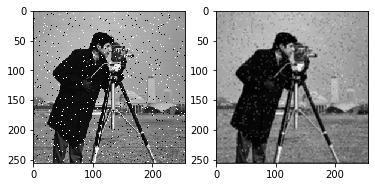

In [84]:
plt.subplot(1,2,1)
imshow(image_cameraman_bruit_impuls, cmap='gray')
plt.subplot(1,2,2)
imshow(filtre_moyenneur(image_cameraman_bruit_impuls,3), cmap='gray')

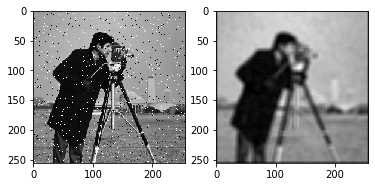

In [85]:
plt.subplot(1,2,1)
imshow(image_cameraman_bruit_impuls, cmap='gray')
plt.subplot(1,2,2)
imshow(filtre_moyenneur(image_cameraman_bruit_impuls,9), cmap='gray')

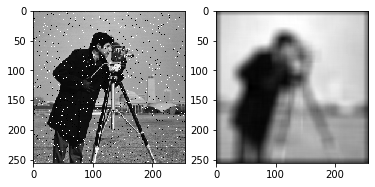

In [86]:
plt.subplot(1,2,1)
imshow(image_cameraman_bruit_impuls, cmap='gray')
plt.subplot(1,2,2)
imshow(filtre_moyenneur(image_cameraman_bruit_impuls,21), cmap='gray')

### Remarques:
Plus le filtre est large, plus le bruit est attenue, mais plus la qualite de l’image est dégradée 

### image_cameraman_bruit_gauss

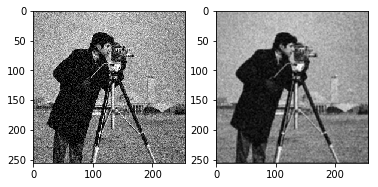

In [44]:
plt.subplot(1,2,1)
imshow(image_cameraman_bruit_gauss, cmap='gray')
plt.subplot(1,2,2)
imshow(filtre_moyenneur(image_cameraman_bruit_gauss,3), cmap='gray')

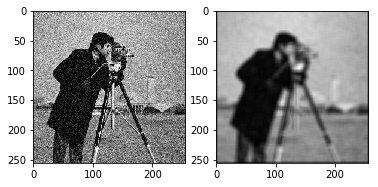

In [45]:
plt.subplot(1,2,1)
imshow(image_cameraman_bruit_gauss, cmap='gray')
plt.subplot(1,2,2)
imshow(filtre_moyenneur(image_cameraman_bruit_gauss,9), cmap='gray')

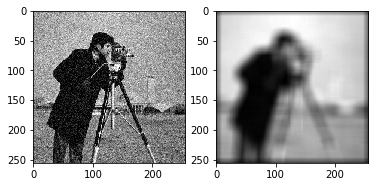

In [46]:
plt.subplot(1,2,1)
imshow(image_cameraman_bruit_gauss, cmap='gray')
plt.subplot(1,2,2)
imshow(filtre_moyenneur(image_cameraman_bruit_gauss,21), cmap='gray')

### Conclusion:
On se rend compte que le bruit est diminué par le filtre moyenneur, plus la taille du filtre est grand plus le bruit est diminué, cependant on distingue moins les contours car l'image est floutée, donc le filtre moyenneur n'est pas le meilleur à utiliser si on a envie de diminuer le bruit car on perd aussi des propriétés de l'image. Sinon, utiliser un filtre moyenneur petit.

## Partie 3 : Réduction de bruit par filtrage non linéaire: le filtre médian

Dans cette partie, on cherchera à filtrer le bruit d'une image en utilisant un filtre médian. On rappelle que le filtre médian remplace chaque pixel par la valeur médiane dans son voisinage.

### Exercice 3.1: Implémentation du filtre médian

**À faire**: Implémentez le filtre médian pour une fenêtre de taille $N\times N$ variable. 

On utilisera un padding linéaire de l'image pour adapter les dimensions de l'image. Vous pouvez écrire une fonction utilisant un tri. Il est interdit d'utiliser des filtres médians déjà implémenté dans les modules Python.

On supposera que le voisinnage du pixel est un carré de coté impaire, centré en ce pixel.


In [59]:
def median_case(image, x,y, N):
    l=[]
    d=(N-1)//2
    for i in range(x-d, x+d+1):
        for j in range(y-d, y+d+1):
            l.append(image[i][j])
    #Tri de la liste obtenu
    l.sort()
    #on récupère l'indice de l'élément médian
    indice=(len(l)//2)
    return l[indice]

In [60]:
def filtre_median(image, N):
        """ Array*int -> Array
            retourne l'image filtré par un médian de taille N
        """
        #on récupère la valeur à utiliser pour le padding
        l1=(N-1)//2
        img=padding_image(image, l1)
        (h,w)=image.shape
        newImage=np.zeros((h,w))
        #application du filtre median à toute les case de l'image
        for i in range(h):
            for j in range(w):
                newImage[i][j]=median_case(img, i+l1, j+l1, N)
        return newImage

Vérification: vous pouvez vérifier votre fonction en le comparant le résultat à celui obtenu avec le filtre médian de scipy. La norme de la différence doit être proche de 0.

In [61]:
import scipy.ndimage.filters
np.linalg.norm(filtre_median(image_cameraman, 5) - scipy.ndimage.filters.median_filter(image_cameraman, size=(5, 5), mode='constant'))

0.0

### résultat du test: 
0.0

### Exercice 3.2 : Utilisation du filtre médian pour le débruitage

Appliquez le filtre médian à l'image `image_cameraman_bruit_gauss` et à l'image `image_cameraman_bruit_impuls` en utilisant des fenetres de différentes tailles, par exemple $3\times3$, $9\times9$ et $21\times21$. Que remarquez vous ? Comparez le résultat avec celui obtenu avec le filtre moyenneur. Que concluez vous ?

### image_cameraman_bruit_impuls

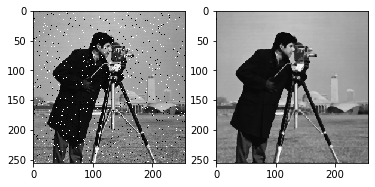

In [63]:
plt.subplot(1,2,1)
imshow(image_cameraman_bruit_impuls, cmap='gray')
plt.subplot(1,2,2)
imshow(filtre_median(image_cameraman_bruit_impuls,3), cmap='gray')

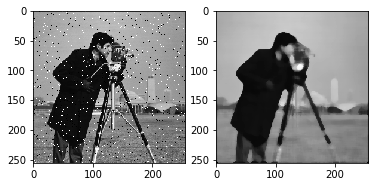

In [64]:
plt.subplot(1,2,1)
imshow(image_cameraman_bruit_impuls, cmap='gray')
plt.subplot(1,2,2)
imshow(filtre_median(image_cameraman_bruit_impuls,9), cmap='gray')

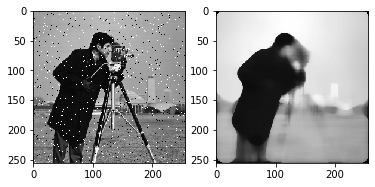

In [65]:
plt.subplot(1,2,1)
imshow(image_cameraman_bruit_impuls, cmap='gray')
plt.subplot(1,2,2)
imshow(filtre_median(image_cameraman_bruit_impuls,21), cmap='gray')

### remarques 
c'est un filtre adapté au bruit type “poivre et sel” (faux blanc et noir dansl’image), mais il faut avoir un filtre de petites dimensions pour ne pas dégrader l'image ( 3*3 est parfait dans le cas de notre image)
Il Préserve les contours

### image_cameraman_bruit_gauss

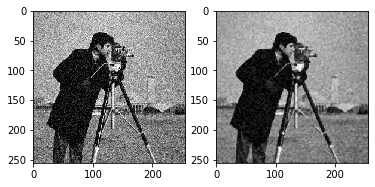

In [66]:
plt.subplot(1,2,1)
imshow(image_cameraman_bruit_gauss, cmap='gray')
plt.subplot(1,2,2)
imshow(filtre_median(image_cameraman_bruit_gauss,3), cmap='gray')


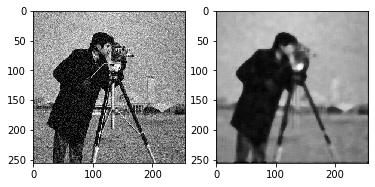

In [67]:
plt.subplot(1,2,1)
imshow(image_cameraman_bruit_gauss, cmap='gray')
plt.subplot(1,2,2)
imshow(filtre_median(image_cameraman_bruit_gauss,9), cmap='gray')

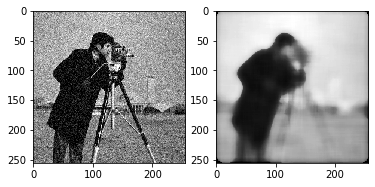

In [68]:
plt.subplot(1,2,1)
imshow(image_cameraman_bruit_gauss, cmap='gray')
plt.subplot(1,2,2)
imshow(filtre_median(image_cameraman_bruit_gauss,21), cmap='gray')

### Conclusion 
Le filtre médian réduit le bruit gaussien (lissage de l’image). Cependant pour préserver la netteté, prendre des filtres ayant de petites dimensions